<a href="https://colab.research.google.com/github/mdpw/pytorch-deep-learning/blob/main/04_cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sumani
# https://www.linkedin.com/in/sumanaruban/
# https://github.com/Sumanaruban
# 3-8-2025

# Building and Training a CNN model on MNIST Dataset Using PyTorch

In this notebook, we will walk through the process of building, training, and evaluating a Convolutional Neural Network (CNN) for classifying handwritten digits from the MNIST dataset using PyTorch. We'll cover data loading and preprocessing, model definition, training, evaluation, and visualization of the results.

## Introduction

The MNIST dataset contains 70,000 grayscale images of handwritten digits (0-9), each of size 28x28 pixels. The dataset is divided into 60,000 training images and 10,000 test images. The goal is to classify each image into one of the 10 digit classes.


## Import Libraries

In [2]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Step 1: Data Loading and Preprocessing

We'll start by defining the transformations to apply to the images and loading the MNIST dataset.

#### MNIST Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a large database of handwritten digits that is commonly used for training various image processing systems. The dataset contains 70,000 images of handwritten digits (0-9) with 60,000 images in the training set and 10,000 images in the test set. Each image is a 28x28 grayscale image, meaning each pixel value ranges from 0 (black) to 255 (white). The dataset is well-suited for training and testing machine learning models in image recognition tasks, and it has become a standard benchmark for evaluating algorithms.



#### torch.utils.data.DataLoader

torch.utils.data.DataLoader is a utility in PyTorch that provides an efficient way to load and preprocess data. It allows for easy batching, shuffling, and parallel data loading using multiple workers. Key features include:

1. `Batching`: Automatically groups data into batches.
2. `Shuffling`: Randomizes the order of data samples, which is important for training neural networks.
3. `Parallel Loading`: Utilizes multiple CPU cores to load data in parallel, reducing the time spent on data loading.

DataLoader is essential for handling large datasets and ensuring efficient data feeding during the training and evaluation of models.

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# Define classes
classes = [str(i) for i in range(10)]

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.08MB/s]


# Step 2: Exploratory Data Analysis (EDA)

Let's visualize some sample images from the MNIST dataset.

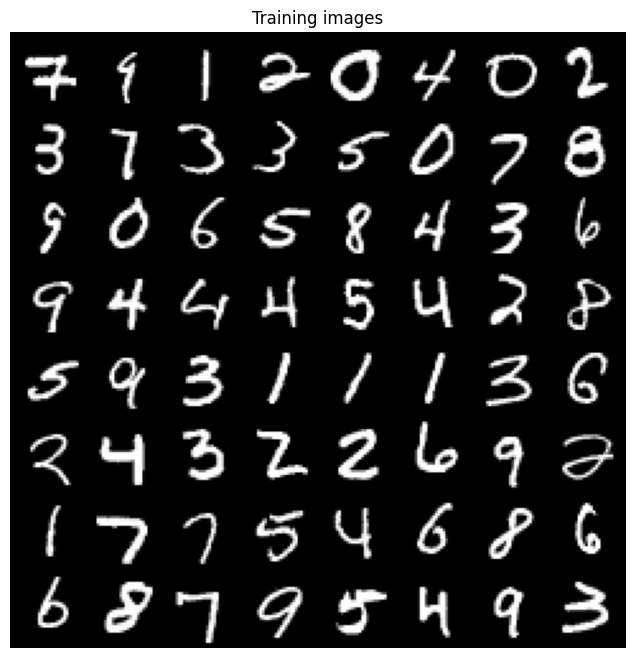

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.utils as vutils

real_batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

# Step 3: Define the Neural Network Model

We will define a simple fully connected neural network with two layers.

In [5]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MNISTModel()

In [6]:
# Create an instance of the model
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTModel()
model = model.to(device)
print(model)

MNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Step 4: Define the Loss Function and Optimizer

We'll use cross-entropy loss and stochastic gradient descent (SGD) optimizer.

#### CrossEntropyLoss

CrossEntropyLoss is a commonly used loss function for classification problems in neural networks. It combines LogSoftmax and NLLLoss (negative log-likelihood loss) in a single class. CrossEntropyLoss is particularly useful for multi-class classification tasks.

#### Adam

The Adam optimizer is a versatile and powerful choice for training deep learning models. Its adaptive learning rate, moment estimation, and bias correction features make it suitable for a wide range of tasks and datasets, offering efficient and effective optimization.

* Efficient: Adam requires only first-order gradients (derivatives) and has a low memory footprint, making it computationally efficient.



In [7]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Training the Model

We train the model and store the training and test losses for each epoch.

In [9]:
num_epochs = 3
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total

        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch+1}, Batch {i + 1}, Train Accuracy: {train_accuracy :.2f}')

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

Epoch 1, Batch 200, Train Accuracy: 97.88
Epoch 1, Batch 400, Train Accuracy: 97.94
Epoch 1, Batch 600, Train Accuracy: 97.88
Epoch 1, Train Loss: 0.0723, Train Accuracy: 97.88%, Test Loss: 0.0321, Test Accuracy: 98.89%
Epoch 2, Batch 200, Train Accuracy: 98.30
Epoch 2, Batch 400, Train Accuracy: 98.31
Epoch 2, Batch 600, Train Accuracy: 98.34
Epoch 2, Train Loss: 0.0582, Train Accuracy: 98.34%, Test Loss: 0.0304, Test Accuracy: 99.03%
Epoch 3, Batch 200, Train Accuracy: 98.33
Epoch 3, Batch 400, Train Accuracy: 98.39
Epoch 3, Batch 600, Train Accuracy: 98.43
Epoch 3, Train Loss: 0.0518, Train Accuracy: 98.43%, Test Loss: 0.0267, Test Accuracy: 99.07%
Finished Training


# Step 6: Evaluating the Model

We'll define a function to evaluate the model on the test dataset.

In [10]:
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

In [11]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}')
    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, testloader, criterion)


Test Loss: 0.0267, Test Accuracy: 0.9907


# Step 7: Visualization

## Visualize Training and Test Loss

We plot the training and test losses over epochs.

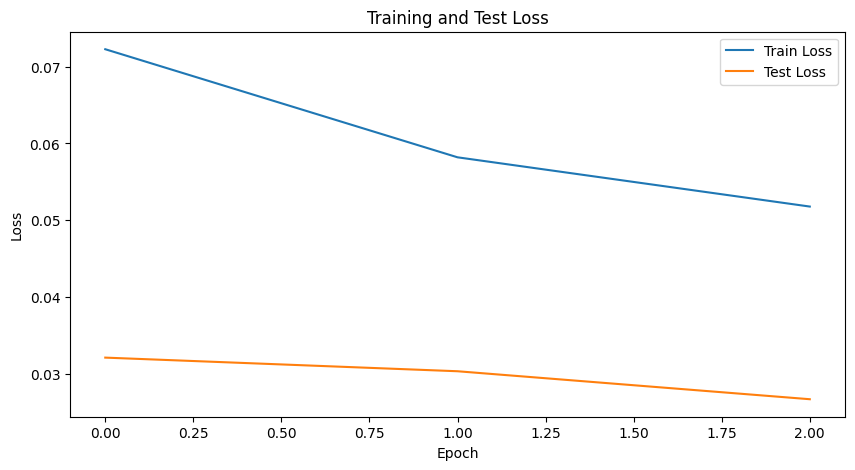

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

## Visualize Training and Test Accuracy

We plot the training and test accuracies over epochs.

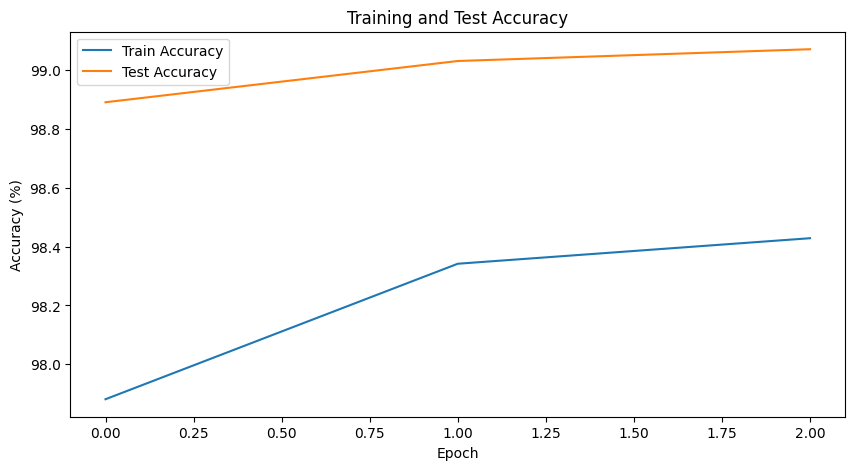

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

## Visualizing Predictions

Finally, let's visualize some sample predictions from the model.

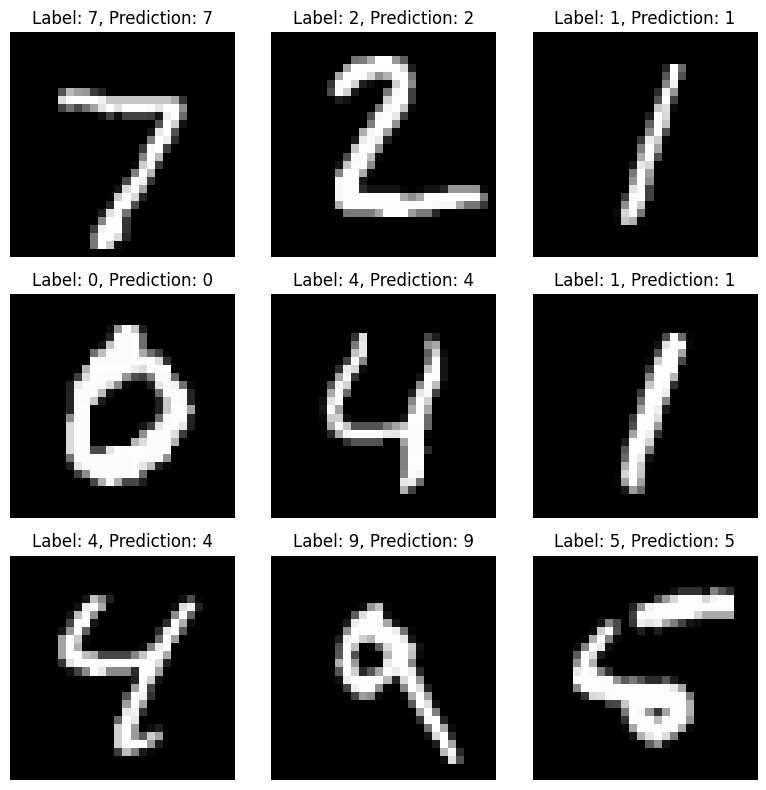

In [14]:
# Visualize some sample images and predictions
samples, labels = next(iter(testloader))
samples, labels = samples.to(device), labels.to(device)
outputs = model(samples)
_, preds = torch.max(outputs, 1)
samples = samples.cpu().numpy()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i]}, Prediction: {preds[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Visualizing Incorrect Predictions

Finally, let's visualize some sample predictions from the model.

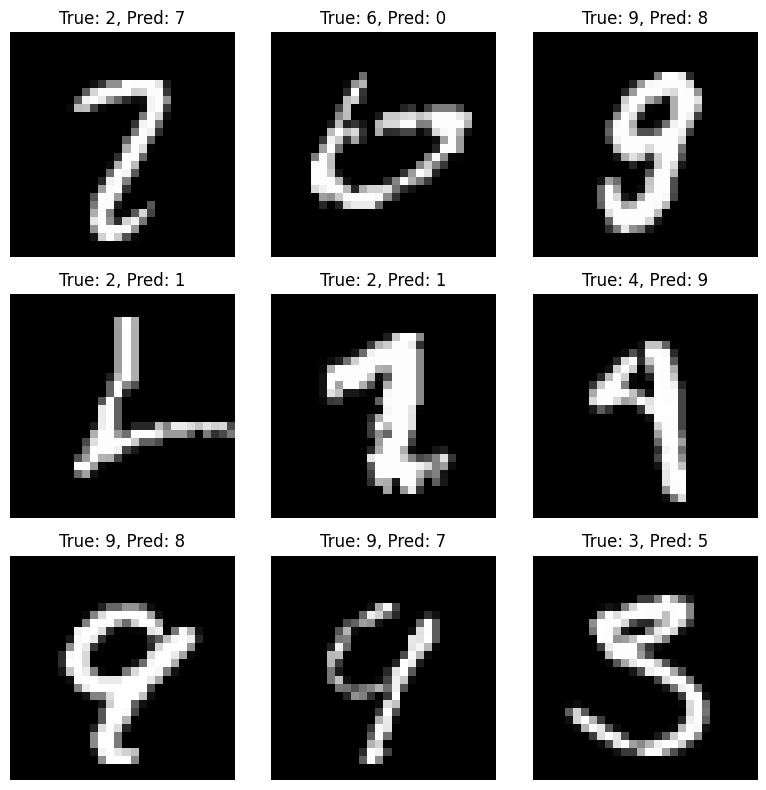

In [15]:
# Visualize incorrect predictions
incorrect = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    idx = incorrect[i]
    ax.imshow(testloader.dataset[idx][0][0], cmap='gray')
    ax.set_title(f'True: {all_labels[idx]}, Pred: {all_preds[idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Evaluate the Model with a Confusion Matrix

We compute the confusion matrix for the test set.

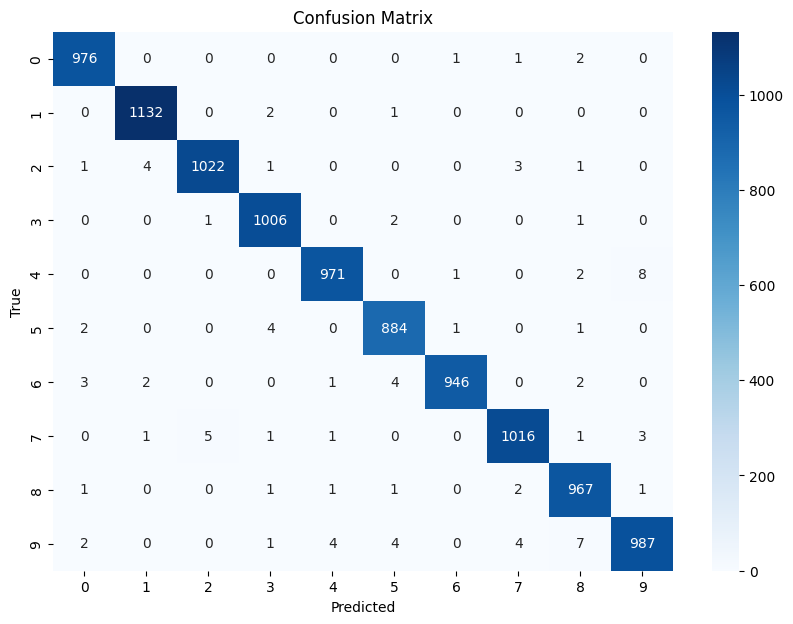

In [16]:
all_labels = []
all_predicted = []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predicted)
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
